# Imports and Definitions

In [1]:
from matplotlib import rcParams
from matplotlib.lines import Line2D
from os import makedirs
from seaborn import pointplot, set_context, set_style
from zipfile import ZipFile
import matplotlib.pyplot as plt
BENCHMARK_CONSENSUS_ZIP = 'data/benchmarks-consensus.zip'
BENCHMARK_EPI_ZIP = 'data/benchmarks-epi.zip'
FIGDIR = 'figs'; makedirs(FIGDIR, exist_ok=True)
RC = {"font.size":12,"axes.titlesize":16,"axes.labelsize":14,"legend.fontsize":10,"xtick.labelsize":10,"ytick.labelsize":10}
set_context("paper", rc=RC); set_style("ticks"); rcParams['font.family'] = 'serif'
rcParams['patch.edgecolor'] = '4C4C4C' # set boxenplot outlines same as violinplot
META = {
    'c': {  # color
        'chromium': 'blue',
        'cli': 'green',
    },
    'ls': { # linestyle
        'chromium': '-',
        'cli': ':',
    },
    'l': {  # label
        'chromium': 'Web',
        'cli': 'CLI',
        'consensus': 'Consensus',
        'epi': 'Epi',
    },
}

# Analysis

## Load data from zips

In [2]:
data = dict() # data['consensus'/'epi']['time'/'memory']['chromium'/'cli'][n] = list of measurements
for pipeline, zip_fn in [('consensus', BENCHMARK_CONSENSUS_ZIP), ('epi', BENCHMARK_EPI_ZIP)]:
    data[pipeline] = dict(); z = ZipFile(zip_fn)
    for m, m_suf in [('time', '/time.log'), ('mem', '/memory.log')]:
        data[pipeline][m] = dict()
        for curr_fn in [fn for fn in z.namelist() if fn.endswith(m_suf)]:
            folder, tool = curr_fn.split('/')[:-1]
            if tool not in data[pipeline][m]:
                data[pipeline][m][tool] = dict()
            n, r = [int(v) for v in folder.rstrip('/').strip().split('.')]
            if n not in data[pipeline][m][tool]:
                data[pipeline][m][tool][n] = list()
            data[pipeline][m][tool][n].append(float(z.read(curr_fn).decode()))

## Plot runtime and peak memory vs. *n*

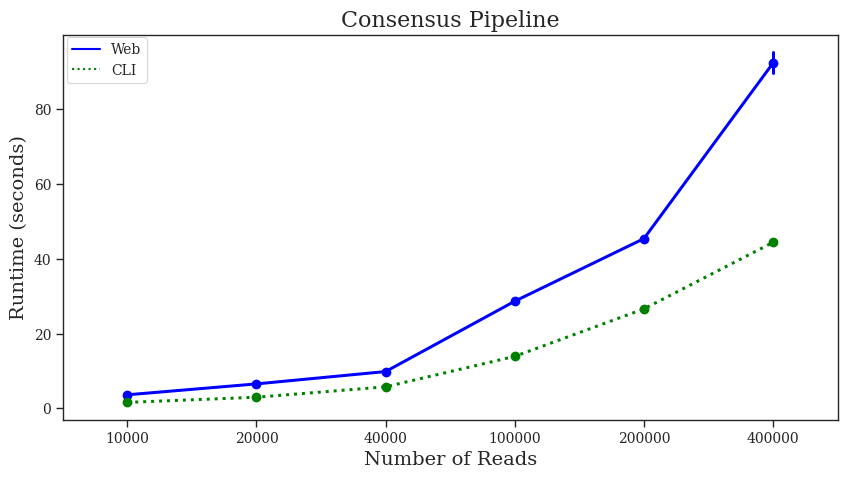

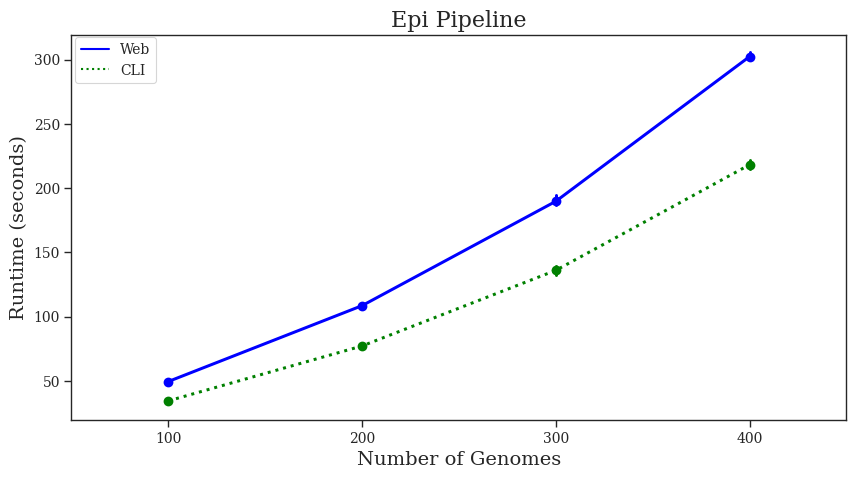

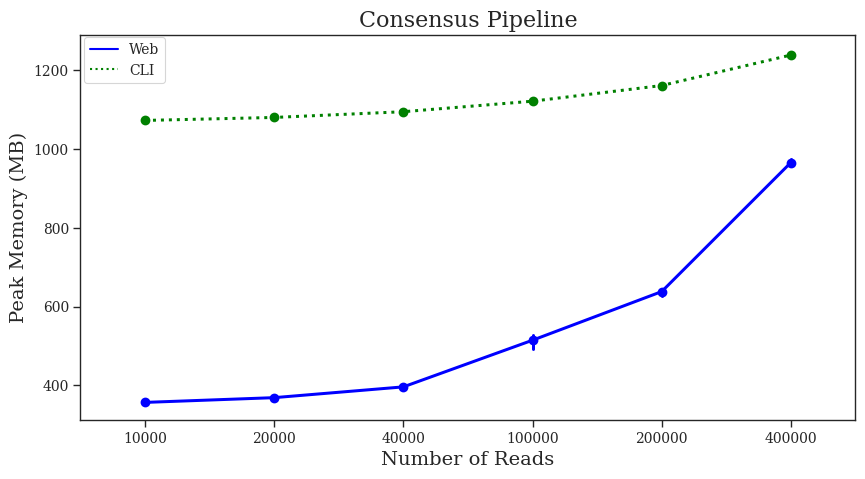

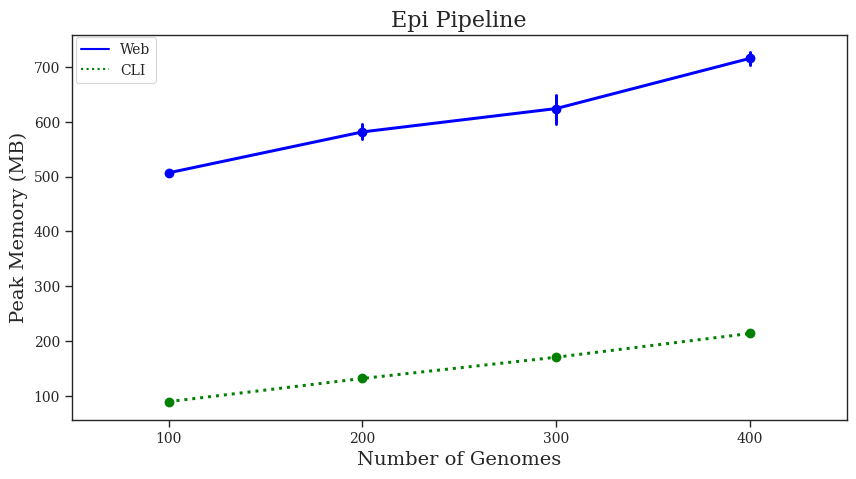

In [3]:
for plot in ['time', 'mem']:
    for pipeline in ['consensus', 'epi']:
        fig, ax = plt.subplots(figsize=(10,5)); handles = list()
        for tool in ['chromium', 'cli']:
            handles.append(Line2D([0],[0], color=META['c'][tool], label=META['l'][tool], linewidth=1.5, linestyle=META['ls'][tool]))
            x = list(); y = list()
            for n in sorted(data[pipeline][plot][tool].keys()):
                tmp = data[pipeline][plot][tool][n]
                if plot == 'mem': # convert KB to MB
                    tmp = [v/1024. for v in tmp]
                y += tmp; x += [n]*len(tmp)
            pointplot(x=x, y=y, color=META['c'][tool], linestyles=META['ls'][tool])
        plt.title('%s Pipeline' % META['l'][pipeline])
        if pipeline == 'consensus':
            plt.xlabel('Number of Reads')
        else:
            plt.xlabel('Number of Genomes')
        if plot == 'time':
            plt.ylabel('Runtime (seconds)')
        else:
            plt.ylabel('Peak Memory (MB)')
        plt.legend(handles=handles,bbox_to_anchor=(0.005, 0.995), loc=2, borderaxespad=0., frameon=True)
        fig.savefig('%s/%s.%s.pdf' % (FIGDIR, plot, pipeline), format='pdf', bbox_inches='tight')